In [2]:
import requests
import pandas as pd

from barentswatch.credentials import config
from barentswatch.authentication import get_token

In [ ]:

import warnings
from pprintpp import pprint
warnings.simplefilter(action='ignore', category=FutureWarning)

###### Using API to get data

Link to ApiDocs: https://www.barentswatch.no/bwapi/openapi/index.html?urls.primaryName=Fishhealth%20API

In [ ]:
from functions import get_week_summary

In [ ]:
token = get_token()
weeksummary= get_week_summary(token,'2017','45')
type(weeksummary)

Token request successful


dict

In [ ]:
weeksummary

NameError: name 'weeksummary' is not defined

##### Storing information from the entire year in table

In [5]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [7]:
from cassandra.cluster import Cluster
from cassandra.query import SimpleStatement

# Establish a connection to the Cassandra cluster
cluster = Cluster(['127.0.0.1'])  # assuming Cassandra is running on localhost
session = cluster.connect()

session.set_keyspace('fish_data')

table_creation_query = """
    CREATE TABLE IF NOT EXISTS locality_data (
        year INT,
        week INT,
        localityNo INT,
        localityWeekId INT PRIMARY KEY,
        name TEXT,
        hasReportedLice BOOLEAN,
        isFallow BOOLEAN,
        avgAdultFemaleLice DOUBLE,
        hasCleanerfishDeployed BOOLEAN,
        hasMechanicalRemoval BOOLEAN,
        hasSubstanceTreatments BOOLEAN,
        hasPd BOOLEAN,
        hasIla BOOLEAN,
        municipalityNo TEXT,
        municipality TEXT,
        lat DOUBLE,
        lon DOUBLE,
        isOnLand BOOLEAN,
        inFilteredSelection BOOLEAN,
        hasSalmonoids BOOLEAN,
        isSlaughterHoldingCage BOOLEAN
    );
"""
#session.execute(table_creation_query) # Uncomment to create the table

# Define the INSERT statement
insert_query = """
    INSERT INTO locality_data (year, week, localityNo, localityWeekId, name, hasReportedLice, isFallow, 
                               avgAdultFemaleLice, hasCleanerfishDeployed, hasMechanicalRemoval, 
                               hasSubstanceTreatments, hasPd, hasIla, municipalityNo, municipality, 
                               lat, lon, isOnLand, inFilteredSelection, hasSalmonoids, isSlaughterHoldingCage)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
"""

In [8]:

for week in range(1, 53):
    print(f'Inserting data for week {week}...')
    weeksummary = get_week_summary(token, '2021', str(week))

    for locality in weeksummary['localities']:
        session.execute(
            insert_query,
            (
                weeksummary['year'],
                weeksummary['week'],
                locality['localityNo'],
                locality['localityWeekId'],
                locality['name'],
                locality['hasReportedLice'],
                locality['isFallow'],
                locality['avgAdultFemaleLice'],
                locality['hasCleanerfishDeployed'],
                locality['hasMechanicalRemoval'],
                locality['hasSubstanceTreatments'],
                locality['hasPd'],
                locality['hasIla'],
                locality['municipalityNo'],
                locality['municipality'],
                locality['lat'],
                locality['lon'],
                locality['isOnLand'],
                locality['inFilteredSelection'],
                locality['hasSalmonoids'],
                locality['isSlaughterHoldingCage']
            )
        )

#### Extracting yearly information from one specific location into its own table

In [16]:
specific_locality_no = 14746

# Step 1: Retrieve all records for the specific localityNo
query = "SELECT * FROM locality_data WHERE localityNo = %s ALLOW FILTERING"
filtered_records = session.execute(query, [specific_locality_no])

create_table_query = """
CREATE TABLE IF NOT EXISTS locality_data_specific (
    year int,
    week int,
    localityno int,
    localityweekid int,
    name text,
    hasreportedlice boolean,
    isfallow boolean,
    avgadultfemalelice float,
    hascleanerfishdeployed boolean,
    hasmechanicalremoval boolean,
    hassubstancetreatments boolean,
    haspd boolean,
    hasila boolean,
    municipalityno text,
    municipality text,
    lat float,
    lon float,
    isonland boolean,
    infilteredselection boolean,
    hassalmonoids boolean,
    isslaughterholdingcage boolean,
    PRIMARY KEY (localityweekid)
);
"""


session.execute(create_table_query)

insert_query = """
INSERT INTO locality_data_specific (
    year, week, localityno, localityweekid, name, hasreportedlice, isfallow,
    avgadultfemalelice, hascleanerfishdeployed, hasmechanicalremoval, 
    hassubstancetreatments, haspd, hasila, municipalityno, municipality, 
    lat, lon, isonland, infilteredselection, hassalmonoids, 
    isslaughterholdingcage
) VALUES (
    %(year)s, %(week)s, %(localityno)s, %(localityweekid)s, %(name)s, 
    %(hasreportedlice)s, %(isfallow)s, %(avgadultfemalelice)s, 
    %(hascleanerfishdeployed)s, %(hasmechanicalremoval)s, 
    %(hassubstancetreatments)s, %(haspd)s, %(hasila)s, %(municipalityno)s, 
    %(municipality)s, %(lat)s, %(lon)s, %(isonland)s, 
    %(infilteredselection)s, %(hassalmonoids)s, %(isslaughterholdingcage)s
)
"""
for row in filtered_records:
    # Convert the Row object to a dict and make sure keys are lowercase
    record_dict = {key.lower(): value for key, value in row._asdict().items()}
    session.execute(insert_query, record_dict)

# Assuming 'filtered_records' is a list of dictionaries where each dictionary contains the data for one record.
for record in filtered_records:
    session.execute(insert_query, record)

# Close the connection to the Cassandra cluster
cluster.shutdown()

Row(localityweekid=1263260, avgadultfemalelice=None, hascleanerfishdeployed=False, hasila=False, hasmechanicalremoval=False, haspd=False, hasreportedlice=False, hassalmonoids=False, hassubstancetreatments=False, infilteredselection=True, isfallow=True, isonland=False, isslaughterholdingcage=False, lat=65.045867, localityno=14746, lon=12.156933, municipality='Bindal', municipalityno='1811', name='Aarsand', week=25, year=2021)

### Inserting the weather data from Frost

In [5]:
from frost_credentials.credentials import ID
import requests
#Credentials need to be made in a separate file called credentials.py. Where ID is a dictionary with the keys 'client_id' and 'client_secret'

# Insert your own client ID here
client_id = ID['client_id']
client_secret = ID['client_secret']

In [8]:
client_id

'bd045ca6-2e46-4101-9928-38ea6f71b90b'

In [16]:
id = "SN65310"

In [26]:
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': f'{id}',
    'elements': 'mean(air_temperature P1D),\
        sum(precipitation_amount P1D),\
        mean(wind_speed P1D),\
        mean(relative_humidity P1D),\
        mean(seaTemperature P1D),)',
    'referencetime': '2021-01-01/2022-01-01'}
r = requests.get(endpoint, parameters, auth=(client_id,''))

json = r.json()

if r.status_code == 200:
    obs_data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [27]:
obs_data

[{'sourceId': 'SN65310:0',
  'referenceTime': '2021-01-01T00:00:00.000Z',
  'observations': [{'elementId': 'mean(air_temperature P1D)',
    'value': 0.8,
    'unit': 'degC',
    'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 2},
    'timeOffset': 'PT0H',
    'timeResolution': 'P1D',
    'timeSeriesId': 0,
    'performanceCategory': 'C',
    'exposureCategory': '2',
    'qualityCode': 0},
   {'elementId': 'mean(air_temperature P1D)',
    'value': 1.7,
    'unit': 'degC',
    'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 2},
    'timeOffset': 'PT6H',
    'timeResolution': 'P1D',
    'timeSeriesId': 0,
    'performanceCategory': 'C',
    'exposureCategory': '2'},
   {'elementId': 'mean(wind_speed P1D)',
    'value': 2.7,
    'unit': 'm/s',
    'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10},
    'timeOffset': 'PT0H',
    'timeResolution': 'P1D',
    'timeSeriesId': 0,
    'performanceCategory': 'C',
    'exposureCategory':

In [29]:
import pandas as pd

In [33]:
# This will return a Dataframe with all of the observations in a table format
df_total = pd.DataFrame()
for i in range(len(obs_data)):
    row = pd.DataFrame(obs_data[i]['observations'])
    row['referenceTime'] = obs_data[i]['referenceTime']
    row['sourceId'] = obs_data[i]['sourceId']
    df_total = pd.concat([df_total, row])

,index


In [36]:
# These additional columns will be kept
columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df = df_total[columns].copy()
# Convert the time value to something Python understands
df['referenceTime'] = pd.to_datetime(df['referenceTime'])

In [38]:
print(df.shape)
df.head()

(1460, 6)


,sourceId,referenceTime,elementId,value,unit,timeOffset
0,SN65310:0,2021-01-01 00:00:00+00:00,mean(air_temperature P1D),0.8,degC,PT0H
1,SN65310:0,2021-01-01 00:00:00+00:00,mean(air_temperature P1D),1.7,degC,PT6H
2,SN65310:0,2021-01-01 00:00:00+00:00,mean(wind_speed P1D),2.7,m/s,PT0H
3,SN65310:0,2021-01-01 00:00:00+00:00,mean(relative_humidity P1D),81.0,percent,PT0H
4,SN65310:0,2021-01-02 00:00:00+00:00,mean(air_temperature P1D),1.8,degC,PT0H


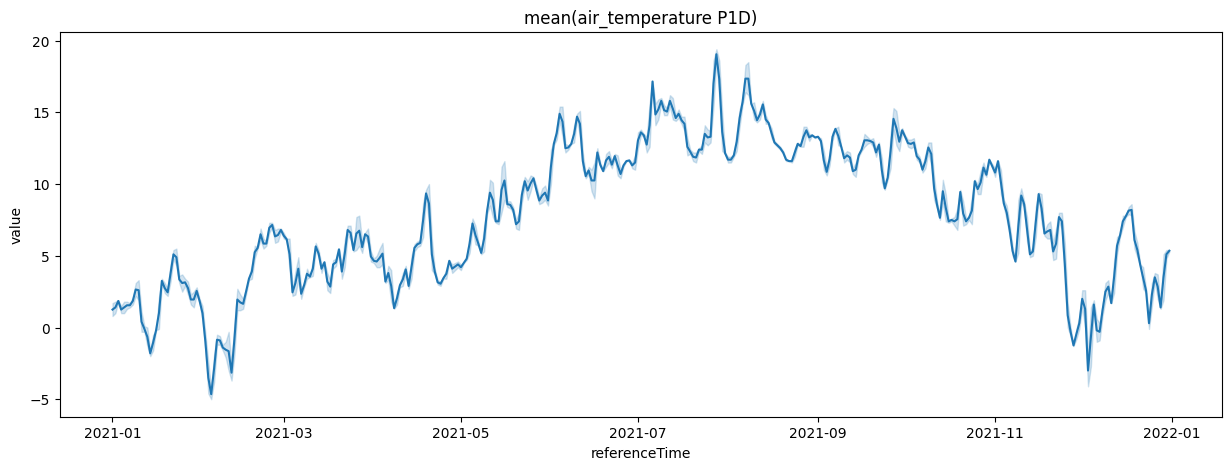

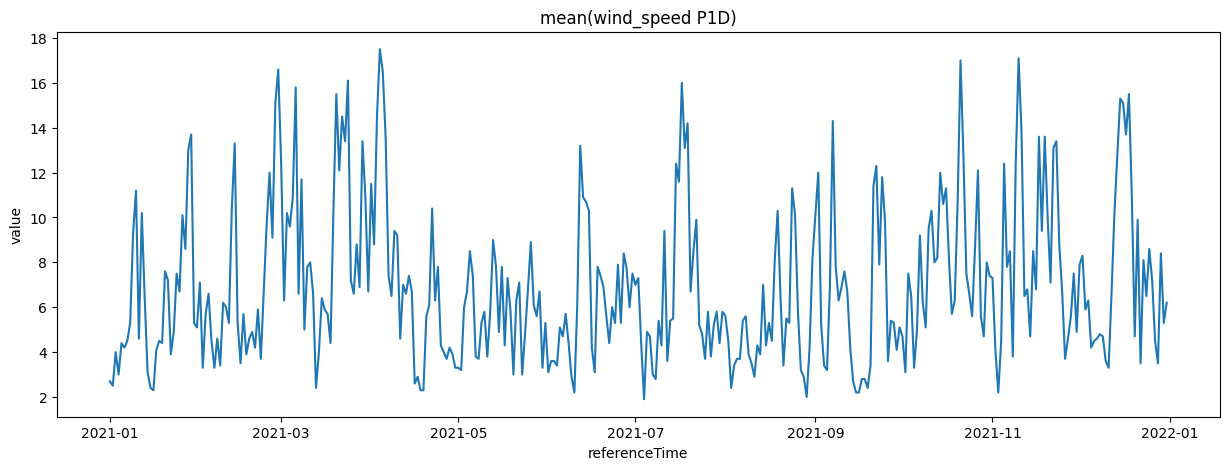

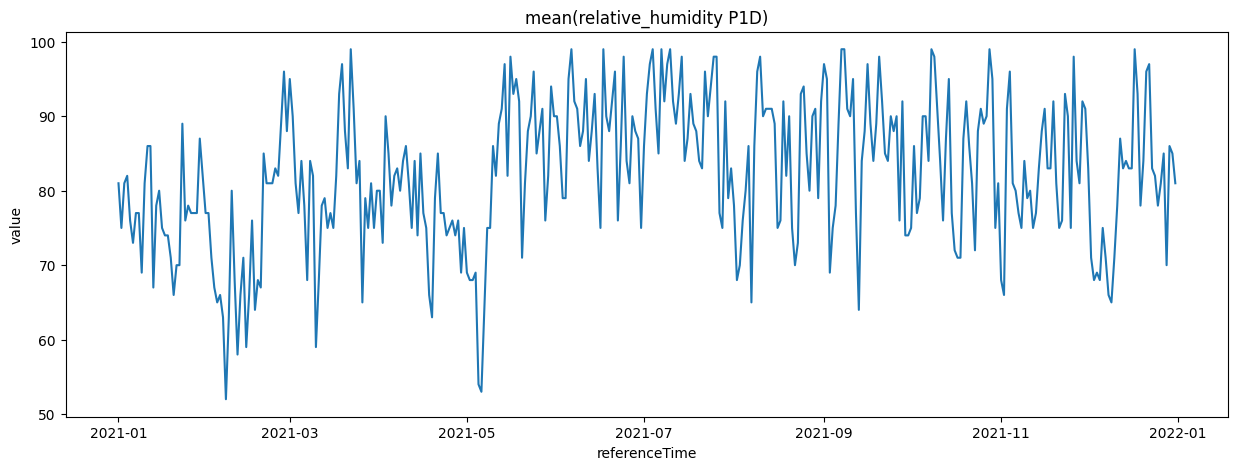

In [41]:
#Plot each of the unique elements from elementId, where x is the referenceTime and y is the value
import matplotlib.pyplot as plt
import seaborn as sns

for element in df['elementId'].unique():
    df_element = df[df['elementId'] == element]
    plt.figure(figsize=(15,5))
    sns.lineplot(x='referenceTime', y='value', data=df_element)
    plt.title(element)
    plt.show()